(gaussian_mixture)=
# Gaussian mixture model

In this tutorial, we demonstrate how to use BayesBay to retrieve a Gaussian Mixture Model (GMM). GMMs rest on the assumption that a complex probability distribution can be decomposed into simpler Gaussian distributions. By the weighted sum of these individual Gaussians, GMMs enable the calculation of the probability density function (PDF)

$$f(x) = \sum_{i=1}^N \omega_i \cdot \mathcal{N}(x; \mu_i, \sigma_i),$$

where $\mu_i$ and $\sigma_i$ denote the mean and standard deviation of the $i$th Gaussian, $\mathcal{N}(x; \mu_i, \sigma_i)$, and the weights are chosen such that $\sum_{i=1}^N \omega_i = 1$.

GMMs are particularly useful to analyze datasets whose underlying distribution is a combination of different Gaussians. This is a common scenario in real-world data, where the considered statistical population often comprises several distinct subpopulations, each characterized by its own distribution. For example, imagine you have the following height measurements from a mixed group of adults and children:

1. **Children (Aged 8 to 12 years)**
   - Measurements: 4000
   - Mean height: 140 cm
   - Standard deviation: 12 cm
2. **Adult Women**
   - Measurements: 3000
   - Mean height: 162 cm
   - Standard deviation: 5 cm
3. **Adult Men**
   - Measurements: 3000
   - Mean height: 177 cm
   - Standard deviation: 6 cm


The height distribution for the above subgroups each follows a Gaussian distribution, but the combined dataset will have three peaks, which cannot be accurately modeled by a single Gaussian. A GMM can model this dataset as a combination of three Gaussians, each capturing the distribution of one subgroup &ndash; children, adult women, and adult men.

## Import libraries and define constants

In [1]:
import bayesbay as bb
from math import sqrt, pi
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(30)

In [2]:
MEANS = [140, 162, 177]  # Means of the Gaussians
STDS = [12, 5, 6]  # Standard deviations of the Gaussians
WEIGHTS = [0.4, 0.3, 0.3]  # Weights of each Gaussian in the mixture
N_SAMPLES = 10_000 # Number of samples to generate

In [3]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * sqrt(2*pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

## The dataset

In [4]:
assert np.isclose(sum(WEIGHTS), 1), "The weights must sum to 1."

def generate_random_samples(means, stds, weights):
    """Generate random samples for each component of the Gaussian mixture"""
    samples = []
    for mean, std, weight in zip(means, stds, weights):
        n_samples = int(N_SAMPLES * weight) # number of samples for each component
        samples.append(np.random.normal(mean, std, n_samples))
    samples = np.concatenate(samples)
    np.random.shuffle(samples)
    return samples

samples = generate_random_samples(MEANS, STDS, WEIGHTS)

For illustration purposes, we compute the true mixture PDF in the block below and plot it along the histogram of samples.

In [5]:
# Define the range of x-values (i.e., heights) over which to evaluate the PDF
x_min, x_max = min(MEANS) - 3 * max(STDS), max(MEANS) + 3 * max(STDS)
xs = np.linspace(x_min, x_max, 1000)

pdf_true = np.zeros_like(xs)
for mean, std, weight in zip(MEANS, STDS, WEIGHTS):
    pdf_true += weight * gaussian(xs, mean, std)

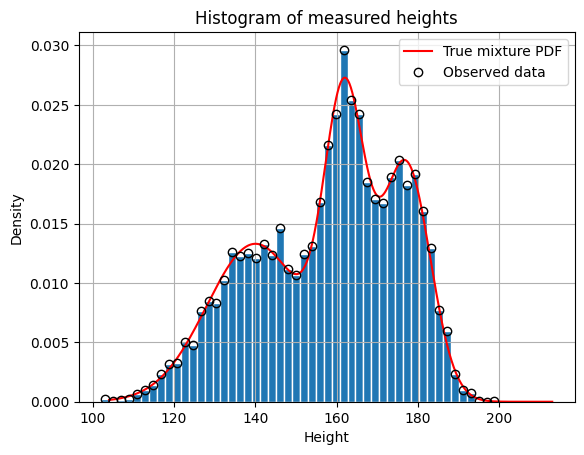

In [6]:
fig, ax = plt.subplots()
ax.set_title('Histogram of measured heights')
data_obs, bins, _ = ax.hist(samples, bins=50, density=True, ec='w')
data_x = (bins[:-1] + bins[1:]) / 2 # take the midpoint of each bin
plt.plot(xs, pdf_true, label='True mixture PDF', color='r')
plt.plot(data_x, data_obs, 'ko', label='Observed data', markerfacecolor='None')

ax.set_xlabel('Height')
ax.set_ylabel('Density')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

To solve the inverse problem inherent in inferring the mean $\boldsymbol{\mu}$, standard deviation $\boldsymbol{\sigma}$, and weight $\boldsymbol{\omega}$ of each Gaussian in the mixture, we need to define:

* A [Parameterization](../api/generated/bayesbay.parameterization.Parameterization), encapsulating the unknown model parameters $\mathbf{m} = [ \boldsymbol{\mu}, \boldsymbol{\sigma}, \boldsymbol{\omega}]$ and their prior probability
* A *forward function*, enabling the prediction of data points $\mathbf{d}_{pred}$ from the model $\mathbf{m}$
* What we refer to as a [Target](../api/generated/bayesbay.Target), that is, a Python object designed to store all information about a given data set

### **Prior probability**

Here, we assume that the number of Gaussians in the mixture is known and
* $100 \leq \mu_i \leq 200$ cm
* $1 \leq \sigma_i \leq 20$ cm
* $0 \leq \omega_i \leq 1$.

In BayesBay, the above prior information can be implemented through [UniformParameter](../api/generated/bayesbay.parameters.UniformParameter), that is, a free parameter characterized by a uniform prior probability. (Different options for the prior of a free parameter can be implemented via [GaussianParameter](../api/generated/bayesbay.parameters.GaussianParameter) or [CustomParameter](../api/generated/bayesbay.parameters.CustomParameter).)

Finally, note the argument ``perturb_std`` in the below block, taken by `UniformParameter`. The numerical value assigned to this argument represents the standard deviation of the Gaussian used to propose a new model by perturbing the considered parameter at a given Markov-chain iteration.

In [7]:
mean = bb.parameters.UniformParameter(name="mean", vmin=100, vmax=200, perturb_std=5)
std = bb.parameters.UniformParameter(name="std", vmin=1, vmax=20, perturb_std=1)
weight = bb.parameters.UniformParameter(name="weight", vmin=0, vmax=1, perturb_std=0.05)

### **Parameter space and parameterization**

The above free parameters should be used in BayesBay to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). Mathematically, `ParameterSpace` can be thought of as a $n$-dimensional vector space. Each point (vector) within this space corresponds to a free parameter in the inference problem, and the position of each point defines the model parameters $\mathbf{m}_i \in \mathbb{R}^n$, with $\mathbf{m}_i \subseteq \mathbf{m}$. Importantly, in our implementation $n$ can be treated as a variable to enable [trans-dimensional Bayesian sampling]((transd_gaussian_mixture)).

From a computer programming perspective, `ParameterSpace` could be seen as a specialized container that not only groups a number of free parameters but also determines their dimensionality. For instance, in this tutorial's case, `ParameterSpace` will contain three distinct free parameters (namely, $\boldsymbol{\omega}$, $\boldsymbol{\mu}$, and $\boldsymbol{\sigma}$); since each of these parameters is a vector of three dimensions (because there are three Gaussians in the mixture), `ParameterSpace`'s dimensionality will remain fixed and equal to three throughout the inversion. Finally, under the hood `ParameterSpace` also defines the perturbation functions used to propose new model parameters from the current ones (for more information, see the module [bayesbridge.perturbations](../api/api_standard_perturbations)).

Having defined one or more instances of `ParameterSpace`, these should be used to define a [Parameterization](../api/generated/bayesbay.parameterization.Parameterization). `Parameterization` is a relatively simple object compared to `ParameterSpace`, and its main purpose is to aggregate all model parameters (from all specified instances of `ParameterSpace`) to define $\mathbf{m} = \lbrace \mathbf{m}_1, \mathbf{m}_2, \mathbf{m}_3, \dots \rbrace$.

In [8]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=3, 
    parameters=[mean, std, weight], 
)
parameterization = bb.parameterization.Parameterization(param_space)

### **Forward problem**

Another fundamental ingredient in BayesBay is the definition of the forward function. This function is required to return the predicted data in the form of a numpy array, which is then used to calculate the likelihood $p({\bf d}_{obs} \mid {\bf m})$. The forward function should be programmed to take in a [bayesbay.State](../api/generated/bayesbay.State), from which all model parameters can be accessed. Within the forward function passed to BayesBay, function calls to external functions, as illustrated in the code block below, are of course allowed.

In [9]:
def _forward(means, stds, weights):
    weights /= np.sum(weights)
    data_pred = np.zeros_like(data_x)
    for i in range(len(means)):
        data_pred += weights[i] * gaussian(data_x, means[i], stds[i])
    return data_pred

def fwd_function(state: bb.State) -> np.ndarray:
    means = state["my_param_space"]['mean']
    stds = state["my_param_space"]['std']
    weights = state["my_param_space"]['weight']
    return _forward(means, stds, weights)

### **Observed data: the Target**

In BayesBay, the observed data should be used to define what we call a data [Target](../api/api_standard_target), which allows for treating the data noise as an unknown. This is accomplished by specifying minimum and maximum bounds for the standard deviation of the data and, optionally, for the data correlation. In this instance, we assume that there is no correlation between adjacent data points.

In [10]:
target = bb.Target("my_data", 
                   data_obs, 
                   std_min=0, 
                   std_max=0.01, 
                   std_perturb_std=0.001,
                   noise_is_correlated=False)

## Run the Bayesian sampling

We can now use all the defined variables to solve the inference problem. The code provided below is self-explanatory. We sample the posterior using ten Markov chains, each run on a separate CPU for 50,000 iterations. The 2,000 iterations are discarded as the burn-in phase. After the burn-in, we save one model every 500 iterations.


Notice the arguments ``targets`` and ``fwd_functions`` of [bayesbay.BayesianInversion](../api/generated/bayesbay.BayesianInversion): rather than accepting only one data target and forward function, as defined earlier, these can accept a list of targets and a list of functions. This flexibility makes it straightforward to carry out joint inversions of multiple datasets, each potentially associated with different forward functions.

In [11]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=target, 
    fwd_functions=fwd_function, 
    n_chains=10, 
    n_cpus=10
)
inversion.run(
    n_iterations=50_000, 
    burnin_iterations=2_000, 
    save_every=500, 
    verbose=False, 
)

## Retrieve the results and plot

In the following block, we first retrieve the samples collected during the inference by calling ``inversion.get_results()``. We then sort each retrieved model (i.e. each saved $\mathbf{m}_i = [ \boldsymbol{\omega}_i, \boldsymbol{\mu}_i, \boldsymbol{\sigma}_i]$, where the subscript $i$ denotes the Markov chain iteration) so as to arrange the mean values $\boldsymbol{\mu}_i$ in increasing order. For example, a model $\mathbf{m} = [(\mu_2, \mu_1, \mu_3), (\sigma_2, \sigma_1, \sigma_3), (\omega_2, \omega_1, \omega_3)]$, with $\mu_1 < \mu_2 < \mu_3$, would be sorted into $\mathbf{m}' = [(\mu_1, \mu_2, \mu_3), (\sigma_1, \sigma_2, \sigma_3), (\omega_1, \omega_2, \omega_3)]$. This allows us to identify the first Gaussian in the mixture as the one with the lowest mean, the second Gaussian as the one with the next lowest mean, and so on.

Note that, without sorting the saved models as explained, the retrieved statistics for each Gaussian (e.g., the median height) would be meaningless. This is because two models that are equivalent in their entries except for the order of the entries, such as $\mathbf{m}$ and $\mathbf{m}'$ above, when passed to the forward function yield the same predicted PDF (i.e., $\mathbf{G}(\mathbf{m}) = \mathbf{G}(\mathbf{m}')$, where $\mathbf{G}(\mathbf{m}) = \sum_{i=1}^3 \omega_i \cdot \mathcal{N}(x; \mu_i, \sigma_i)$).

Having sorted all saved models, we use their median to retrieve a PDF. This PDF will then be compared with the true PDF of the mixture in a subsequent block.

In [12]:
def sort_mixture(means, stds, weights):
    indexes = [np.argsort(row) for row in means]
    for i, idx in enumerate(indexes):
        means[i] = means[i][idx]
        stds[i] = stds[i][idx]
        weights[i] = weights[i][idx]
    return means, stds, weights

results = inversion.get_results()
means, stds, weights = sort_mixture(np.array(results["mean"]), 
                                    np.array(results["std"]), 
                                    np.array(results["weight"]))
pdf_pred = _forward(np.median(means, axis=0), 
                    np.median(stds, axis=0), 
                    np.median(weights, axis=0)
                    )

Before we plot the results, we conduct a quick simulation to estimate the uncertainty in the observed data. We achieve this by first drawing samples from the true PDF to build 10,000 sets of observed data. We use these datasets to calculate 10,000 histograms, from which we then compute each bin height's standard deviation. Finally, we take the median of the thus derived standard deviations. This median will later be compared with the noise standard deviation as inferred through our hierarchical Bayesian sampling.

In [13]:
datasets = [generate_random_samples(MEANS, STDS, WEIGHTS) for _ in range(10000)]
histograms = np.array([np.histogram(dataset, bins=50, density=True)[0] for dataset in datasets])
true_std = np.median(np.std(histograms, axis=0))

We now plot the inferred PDF and data noise standard deviation along with the true ones.

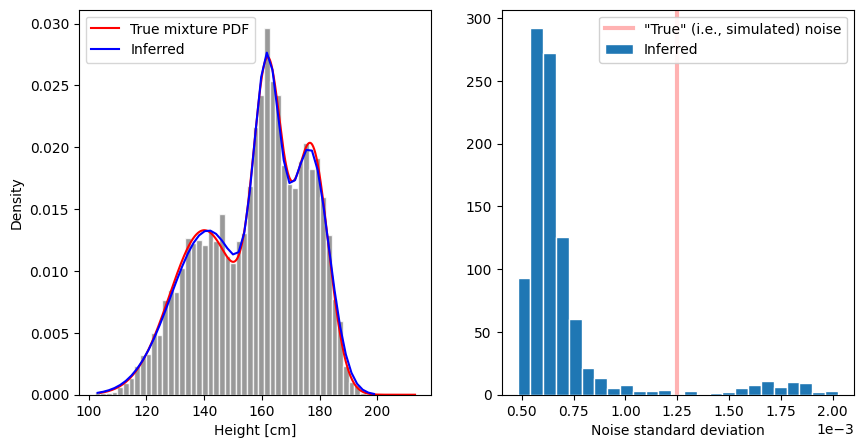

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(samples, bins=50, density=True, ec='w', fc='gray', alpha=0.8)
ax1.plot(xs, pdf_true, label='True mixture PDF', color='r')
ax1.plot(data_x, pdf_pred, label='Inferred', color='b')
ax1.set_xlabel('Height [cm]')
ax1.set_ylabel('Density')
ax1.legend()

ax2.axvline(x=true_std, color='r', lw=3, alpha=0.3, label='"True" (i.e., simulated) noise')
ax2.hist(results['my_data.std'], bins=25, ec='w', zorder=100, label='Inferred')
ax2.set_xlabel('Noise standard deviation')
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.legend(framealpha=0.9)
plt.show()

Finally, we create a figure that displays the inferred mean, standard deviation, and weight for each component of the mixture, with yellow dots indicating the true values. This is achieved using the [ArviZ](https://python.arviz.org/en/latest/index.html) library, which provides useful functionalities for plotting inference results.

/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


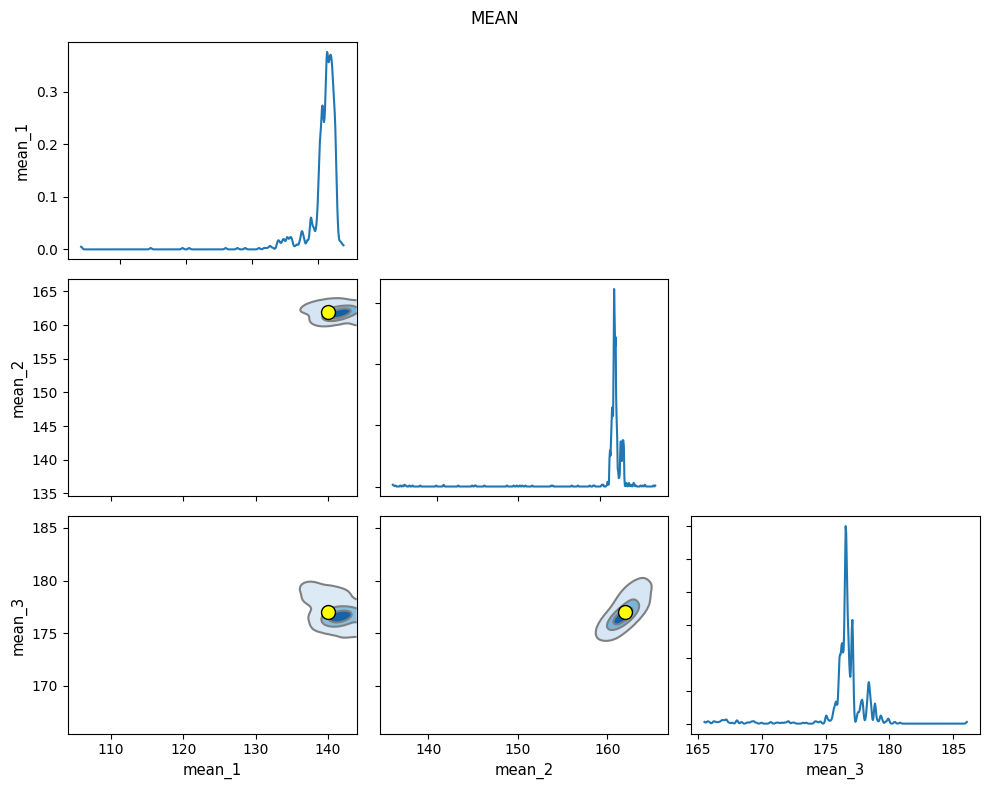

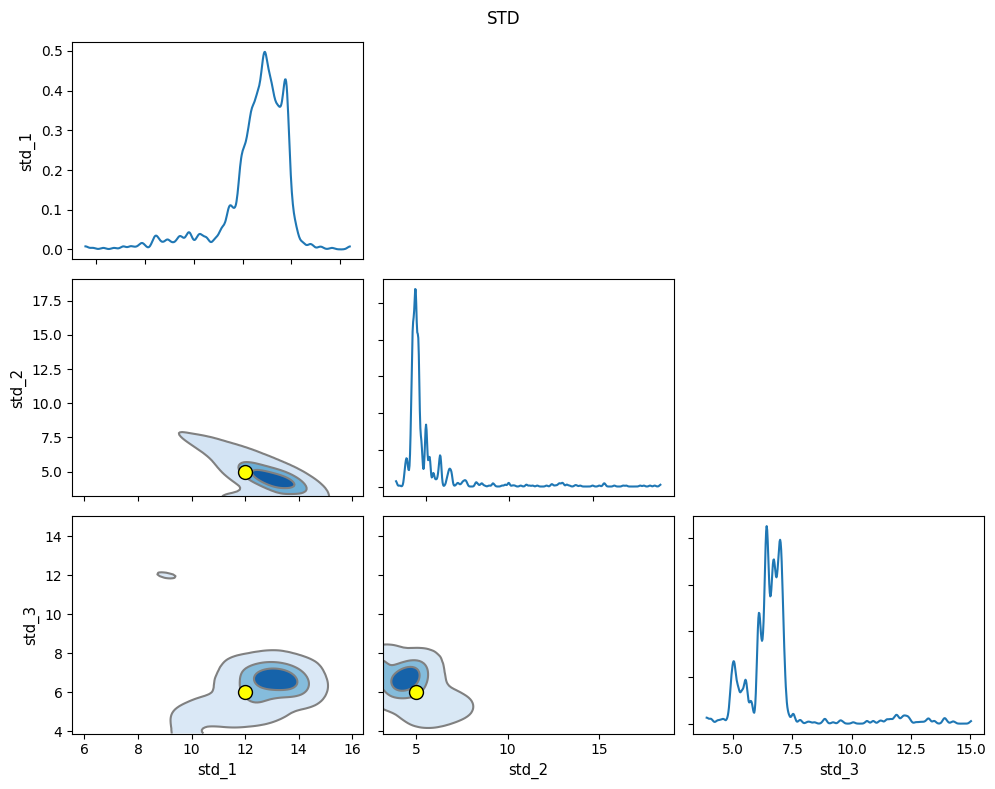

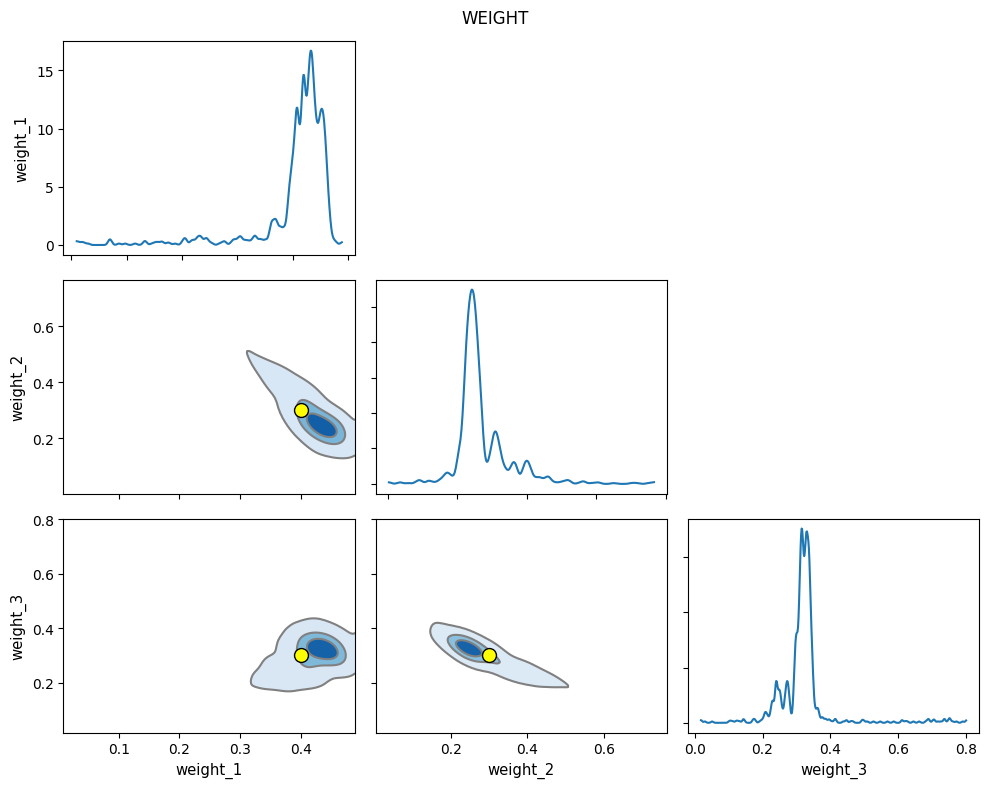

In [15]:
import arviz as az

for key, inferred_value, true_value in zip(
    ['mean', 'std', 'weight'], 
    [means, stds, weights],
    [MEANS, STDS, WEIGHTS]
                     ):
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    _ = az.plot_pair(
        {f'{key}_1': inferred_value[:,0], 
         f'{key}_2': inferred_value[:,1], 
         f'{key}_3': inferred_value[:,2]},
        marginals=True,
        reference_values={f'{key}_1': true_value[0], 
                          f'{key}_2': true_value[1], 
                          f'{key}_3': true_value[2]},
        reference_values_kwargs={'color': 'yellow',
                                 'ms': 10},
        kind='kde',
        kde_kwargs={
            'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            'contourf_kwargs': {'cmap': 'Blues'},
            },
        ax=axes,
        textsize=10
        )
    fig.suptitle(key.upper())
    plt.tight_layout()
    plt.show()